In [125]:
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
import datetime
#from us import states
from scipy.stats import linregress
import scipy.stats as st
from matplotlib import pyplot as plt
from glob import glob
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter
import wget

In [126]:
### BEGIN PALIDA's work on Covid Data ###
### Copying over from Palida's COVID_data_cleaning.ipynb ###

In [127]:
# url of the raw csv dataset
urls = [
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv',
    'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
]

# download data using wget function
[wget.download(url) for url in urls]

['time_series_covid19_confirmed_global (1).csv',
 'time_series_covid19_deaths_global (1).csv',
 'time_series_covid19_recovered_global (1).csv']

In [128]:
# load the data
confirmed_df = pd.read_csv('time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('time_series_covid19_deaths_global.csv')
recovered_df = pd.read_csv('time_series_covid19_recovered_global.csv')

# checking df
confirmed_df
deaths_df
recovered_df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,7/25/20,7/26/20,7/27/20,7/28/20,7/29/20,7/30/20,7/31/20,8/1/20,8/2/20,8/3/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,24793,25180,25198,25358,25389,25471,25509,25509,25510,25669
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,2637,2682,2745,2789,2830,2883,2952,2961,3018,3031
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,18076,18088,18837,19233,19592,20082,20537,20988,21419,21901
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,803,803,803,803,804,806,807,807,807,821
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,242,242,242,266,301,395,437,460,461,476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,Sao Tome and Principe,0.186400,6.613100,0,0,0,0,0,0,...,662,696,734,759,766,771,778,782,787,787
249,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,780,797,833,840,849,856,862,862,862,863
250,NaN,Comoros,-11.645500,43.333300,0,0,0,0,0,0,...,324,328,328,328,330,330,330,330,330,330
251,NaN,Tajikistan,38.861000,71.276100,0,0,0,0,0,0,...,5906,5970,6028,6065,6103,6151,6193,6233,6276,6317


In [129]:
# extracting all of the dates columns
dates = confirmed_df.columns[4:]

# merging all of the confitmed, deaths, and recovered cases using melt function
# at this step we are using province, country, lat, and long as variables for merging
confirmed_df_long = confirmed_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Confirmed'
)
deaths_df_long = deaths_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Deaths'
)
recovered_df_long = recovered_df.melt(
    id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
    value_vars=dates, 
    var_name='Date', 
    value_name='Recovered'
)

# checking the dataframe
confirmed_df_long
deaths_df_long
recovered_df_long

,Province/State,Country/Region,Lat,Long,Date,Recovered
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0
1,NaN,Albania,41.153300,20.168300,1/22/20,0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0
...,...,...,...,...,...,...
49330,NaN,Sao Tome and Principe,0.186400,6.613100,8/3/20,787
49331,NaN,Yemen,15.552727,48.516388,8/3/20,863
49332,NaN,Comoros,-11.645500,43.333300,8/3/20,330
49333,NaN,Tajikistan,38.861000,71.276100,8/3/20,6317


In [130]:
# removing Canada data because it was noted in the datasource about the data mismatched
recovered_df_long = recovered_df_long[recovered_df_long['Country/Region']!='Canada']

# merging two variables at a time
full_table = confirmed_df_long.merge(
  right=deaths_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

# merging again with recovered data
full_table = full_table.merge(
  right=recovered_df_long, 
  how='left',
  on=['Province/State', 'Country/Region', 'Date', 'Lat', 'Long']
)

# create tracker for active case (active - confirmed - death - recovered)
full_table['Active'] = full_table["Confirmed"] - full_table['Deaths'] - full_table['Recovered']

# checking the df
full_table

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Deaths,Recovered,Active
0,NaN,Afghanistan,33.939110,67.709953,1/22/20,0,0,0.0,0.0
1,NaN,Albania,41.153300,20.168300,1/22/20,0,0,0.0,0.0
2,NaN,Algeria,28.033900,1.659600,1/22/20,0,0,0.0,0.0
3,NaN,Andorra,42.506300,1.521800,1/22/20,0,0,0.0,0.0
4,NaN,Angola,-11.202700,17.873900,1/22/20,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
51865,NaN,Sao Tome and Principe,0.186400,6.613100,8/3/20,874,15,787.0,72.0
51866,NaN,Yemen,15.552727,48.516388,8/3/20,1734,499,863.0,372.0
51867,NaN,Comoros,-11.645500,43.333300,8/3/20,386,7,330.0,49.0
51868,NaN,Tajikistan,38.861000,71.276100,8/3/20,7538,61,6317.0,1160.0


In [131]:
# convert date to date time
full_table["Date"] = pd.to_datetime(full_table['Date'])
full_table

# replacing N/A
full_table['Recovered'] = full_table['Recovered'].fillna(0)

In [132]:
# grouping data by setting index and summing
full_grouped = full_table.groupby(['Date', 'Country/Region'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [133]:
full_grouped

,Date,Country/Region,Confirmed,Deaths,Recovered,Active
0,2020-01-22,Afghanistan,0,0,0.0,0.0
1,2020-01-22,Albania,0,0,0.0,0.0
2,2020-01-22,Algeria,0,0,0.0,0.0
3,2020-01-22,Andorra,0,0,0.0,0.0
4,2020-01-22,Angola,0,0,0.0,0.0
...,...,...,...,...,...,...
36655,2020-08-03,West Bank and Gaza,12541,84,5390.0,7067.0
36656,2020-08-03,Western Sahara,10,1,8.0,1.0
36657,2020-08-03,Yemen,1734,499,863.0,372.0
36658,2020-08-03,Zambia,6580,171,4701.0,1708.0


In [134]:
full_grouped.to_csv('../project_data/covid_data/COVID-19-time-series-clean-complete.csv')

In [135]:
### BEGIN PALIDA's work on Global Covid Data Processing ###
### Copying over from Palida's COVID_data_processing (Global).ipynb ###

In [136]:
%matplotlib notebook
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as sts
from matplotlib import pyplot as plt
import altair as alt

In [137]:
# Import and Load CSV

full_grouped = pd.read_csv("../project_data/covid_data/COVID-19-time-series-clean-complete.csv", parse_dates=['Date'], index_col='Country/Region')
full_grouped = full_grouped.reset_index()

# remove the duplicated ID column
del full_grouped['Unnamed: 0']
full_grouped

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
0,Afghanistan,2020-01-22,0,0,0.0,0.0
1,Albania,2020-01-22,0,0,0.0,0.0
2,Algeria,2020-01-22,0,0,0.0,0.0
3,Andorra,2020-01-22,0,0,0.0,0.0
4,Angola,2020-01-22,0,0,0.0,0.0
...,...,...,...,...,...,...
36655,West Bank and Gaza,2020-08-03,12541,84,5390.0,7067.0
36656,Western Sahara,2020-08-03,10,1,8.0,1.0
36657,Yemen,2020-08-03,1734,499,863.0,372.0
36658,Zambia,2020-08-03,6580,171,4701.0,1708.0


In [138]:
full_grouped = full_grouped[(full_grouped['Date'] > '2020-01-22') & (full_grouped['Date'] < '2020-06-30')]
full_grouped

,Country/Region,Date,Confirmed,Deaths,Recovered,Active
188,Afghanistan,2020-01-23,0,0,0.0,0.0
189,Albania,2020-01-23,0,0,0.0,0.0
190,Algeria,2020-01-23,0,0,0.0,0.0
191,Andorra,2020-01-23,0,0,0.0,0.0
192,Angola,2020-01-23,0,0,0.0,0.0
...,...,...,...,...,...,...
30075,West Bank and Gaza,2020-06-29,2185,5,447.0,1733.0
30076,Western Sahara,2020-06-29,10,1,8.0,1.0
30077,Yemen,2020-06-29,1128,304,432.0,392.0
30078,Zambia,2020-06-29,1568,22,1311.0,235.0


<IPython.core.display.Javascript object>


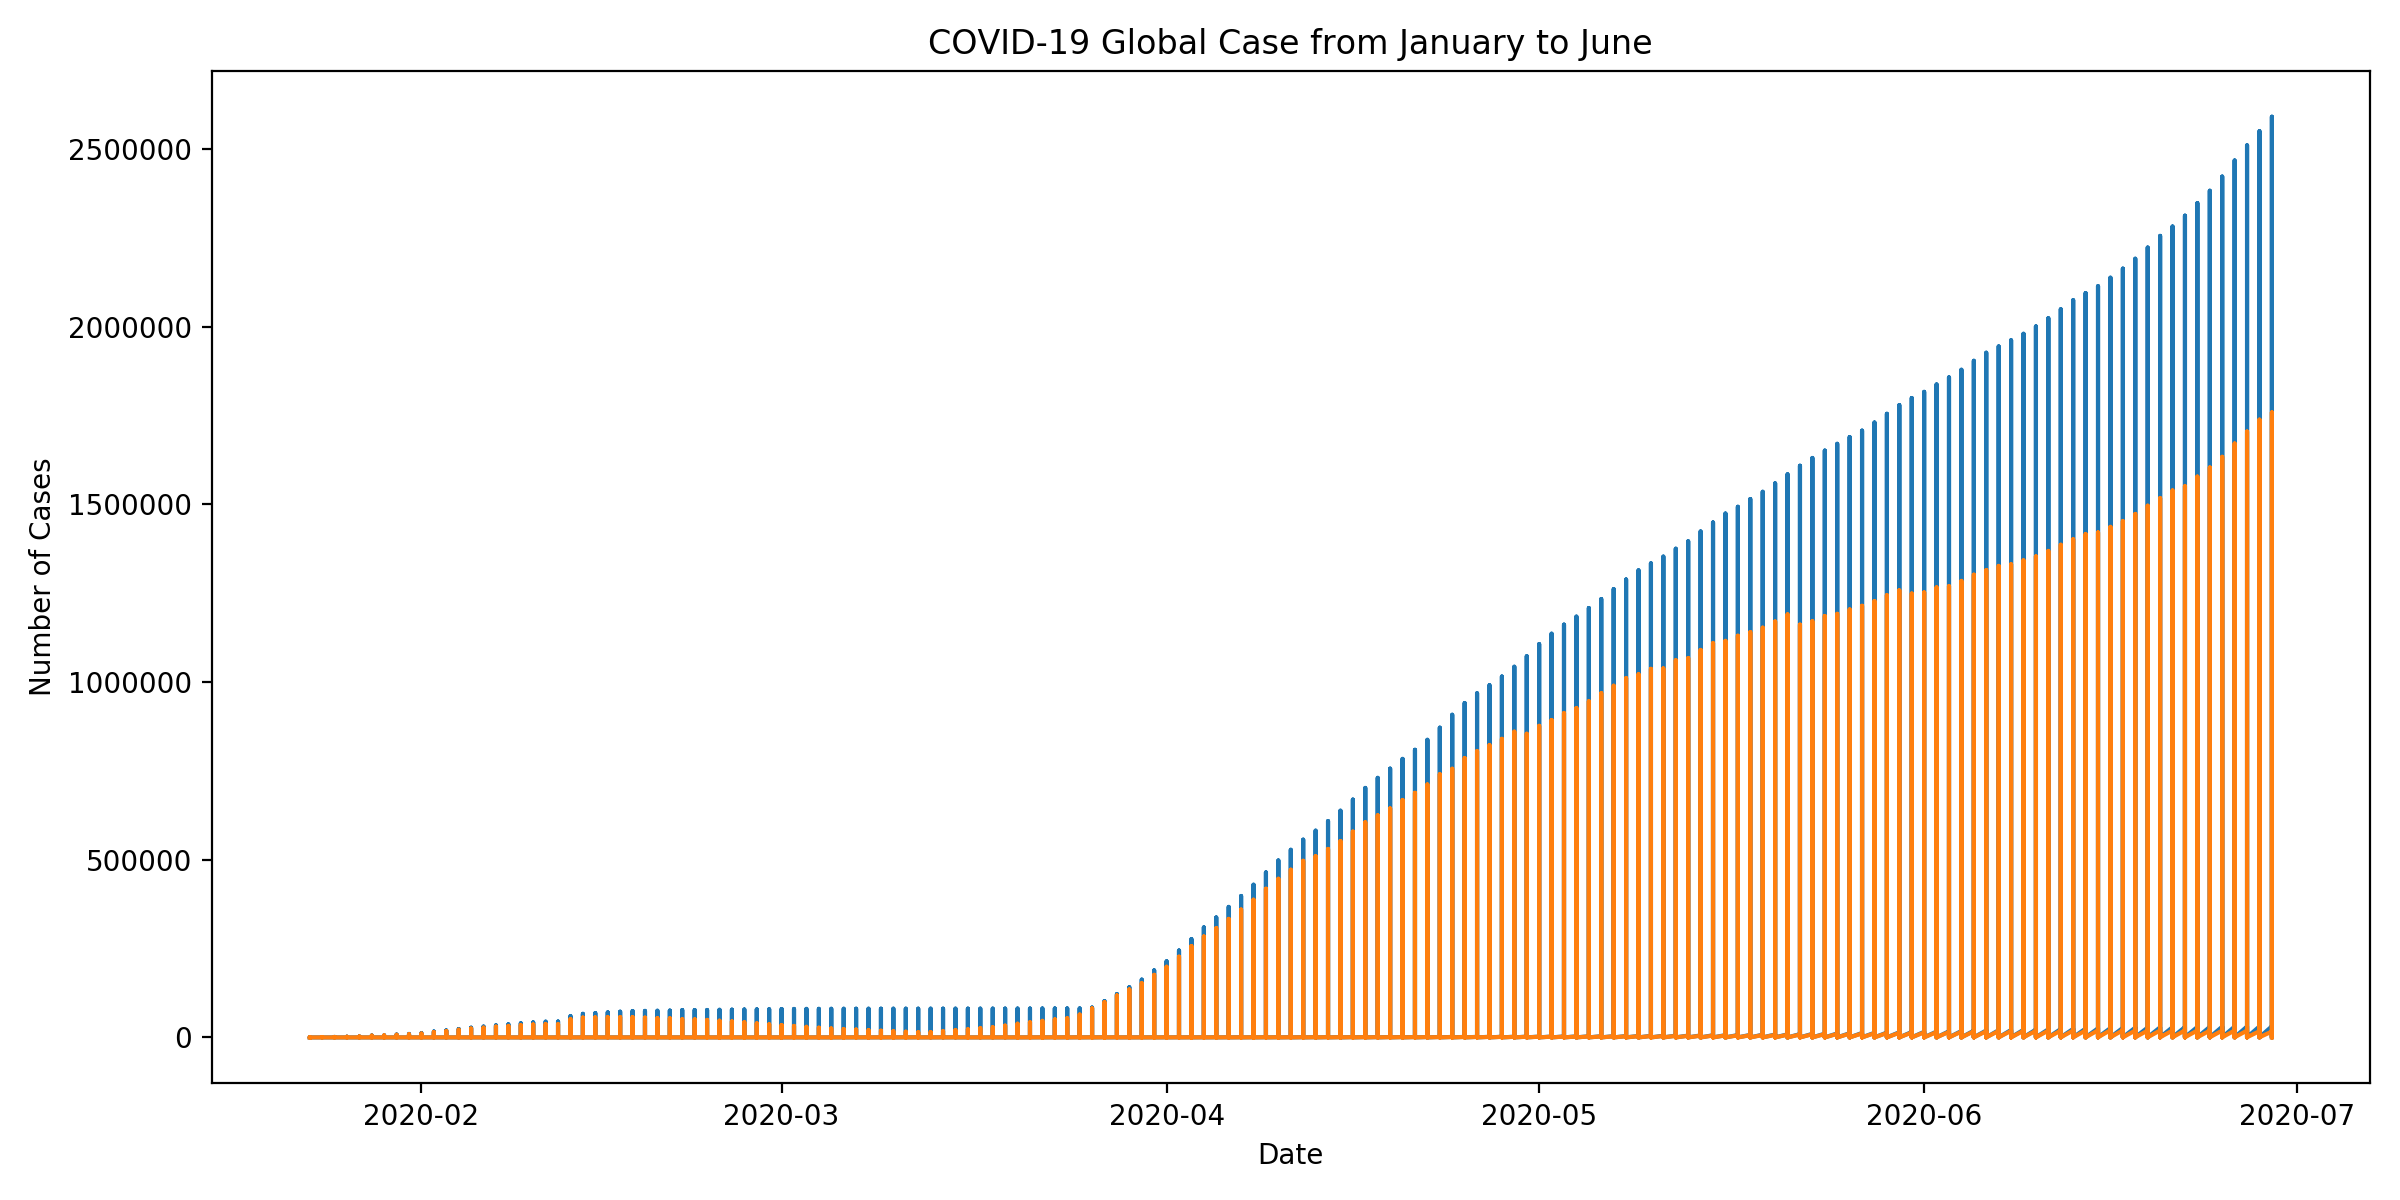

In [139]:
plt.plot(full_grouped['Date'],full_grouped['Confirmed'], label="Total Confirmed COVID-19 Case" )
plt.plot(full_grouped['Date'],full_grouped['Active'], label="Total Active COVID-19 Case" )
plt.title("COVID-19 Global Case from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.tight_layout()
plt.savefig("../images/covid_global.png")
plt.show()

In [140]:
### BEGIN PALIDA's work on US Covid Data Processing ###
### Copying over from Palida's COVID_data_processing(US).ipynb ###

In [141]:
%matplotlib notebook
#Dependencies 
import numpy as np
import pandas as pd
import requests
import time
import json
from scipy.stats import linregress
import scipy.stats as sts
from matplotlib import pyplot as plt
import altair as alt

In [142]:
# Import and Load CSV

full_grouped_file = ("../project_data/covid_data/COVID-19-time-series-clean-complete.csv")

full_grouped_df = pd.read_csv(full_grouped_file)

full_grouped_df

# remove the duplicated ID column
del full_grouped_df['Unnamed: 0']
full_grouped_df

full_grouped_df = full_grouped_df[(full_grouped_df['Date'] > '2020-01-22') & (full_grouped_df['Date'] < '2020-06-31')]
full_grouped_df

us_case = full_grouped_df[full_grouped_df["Country/Region"] == "US"]
us_case


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [143]:
#summary statistics
mean_numpy = np.mean(us_case)
mean_numpy

Confirmed    818659.21250
Deaths        45677.41875
Recovered    174513.36875
Active       598468.42500
dtype: float64

<IPython.core.display.Javascript object>


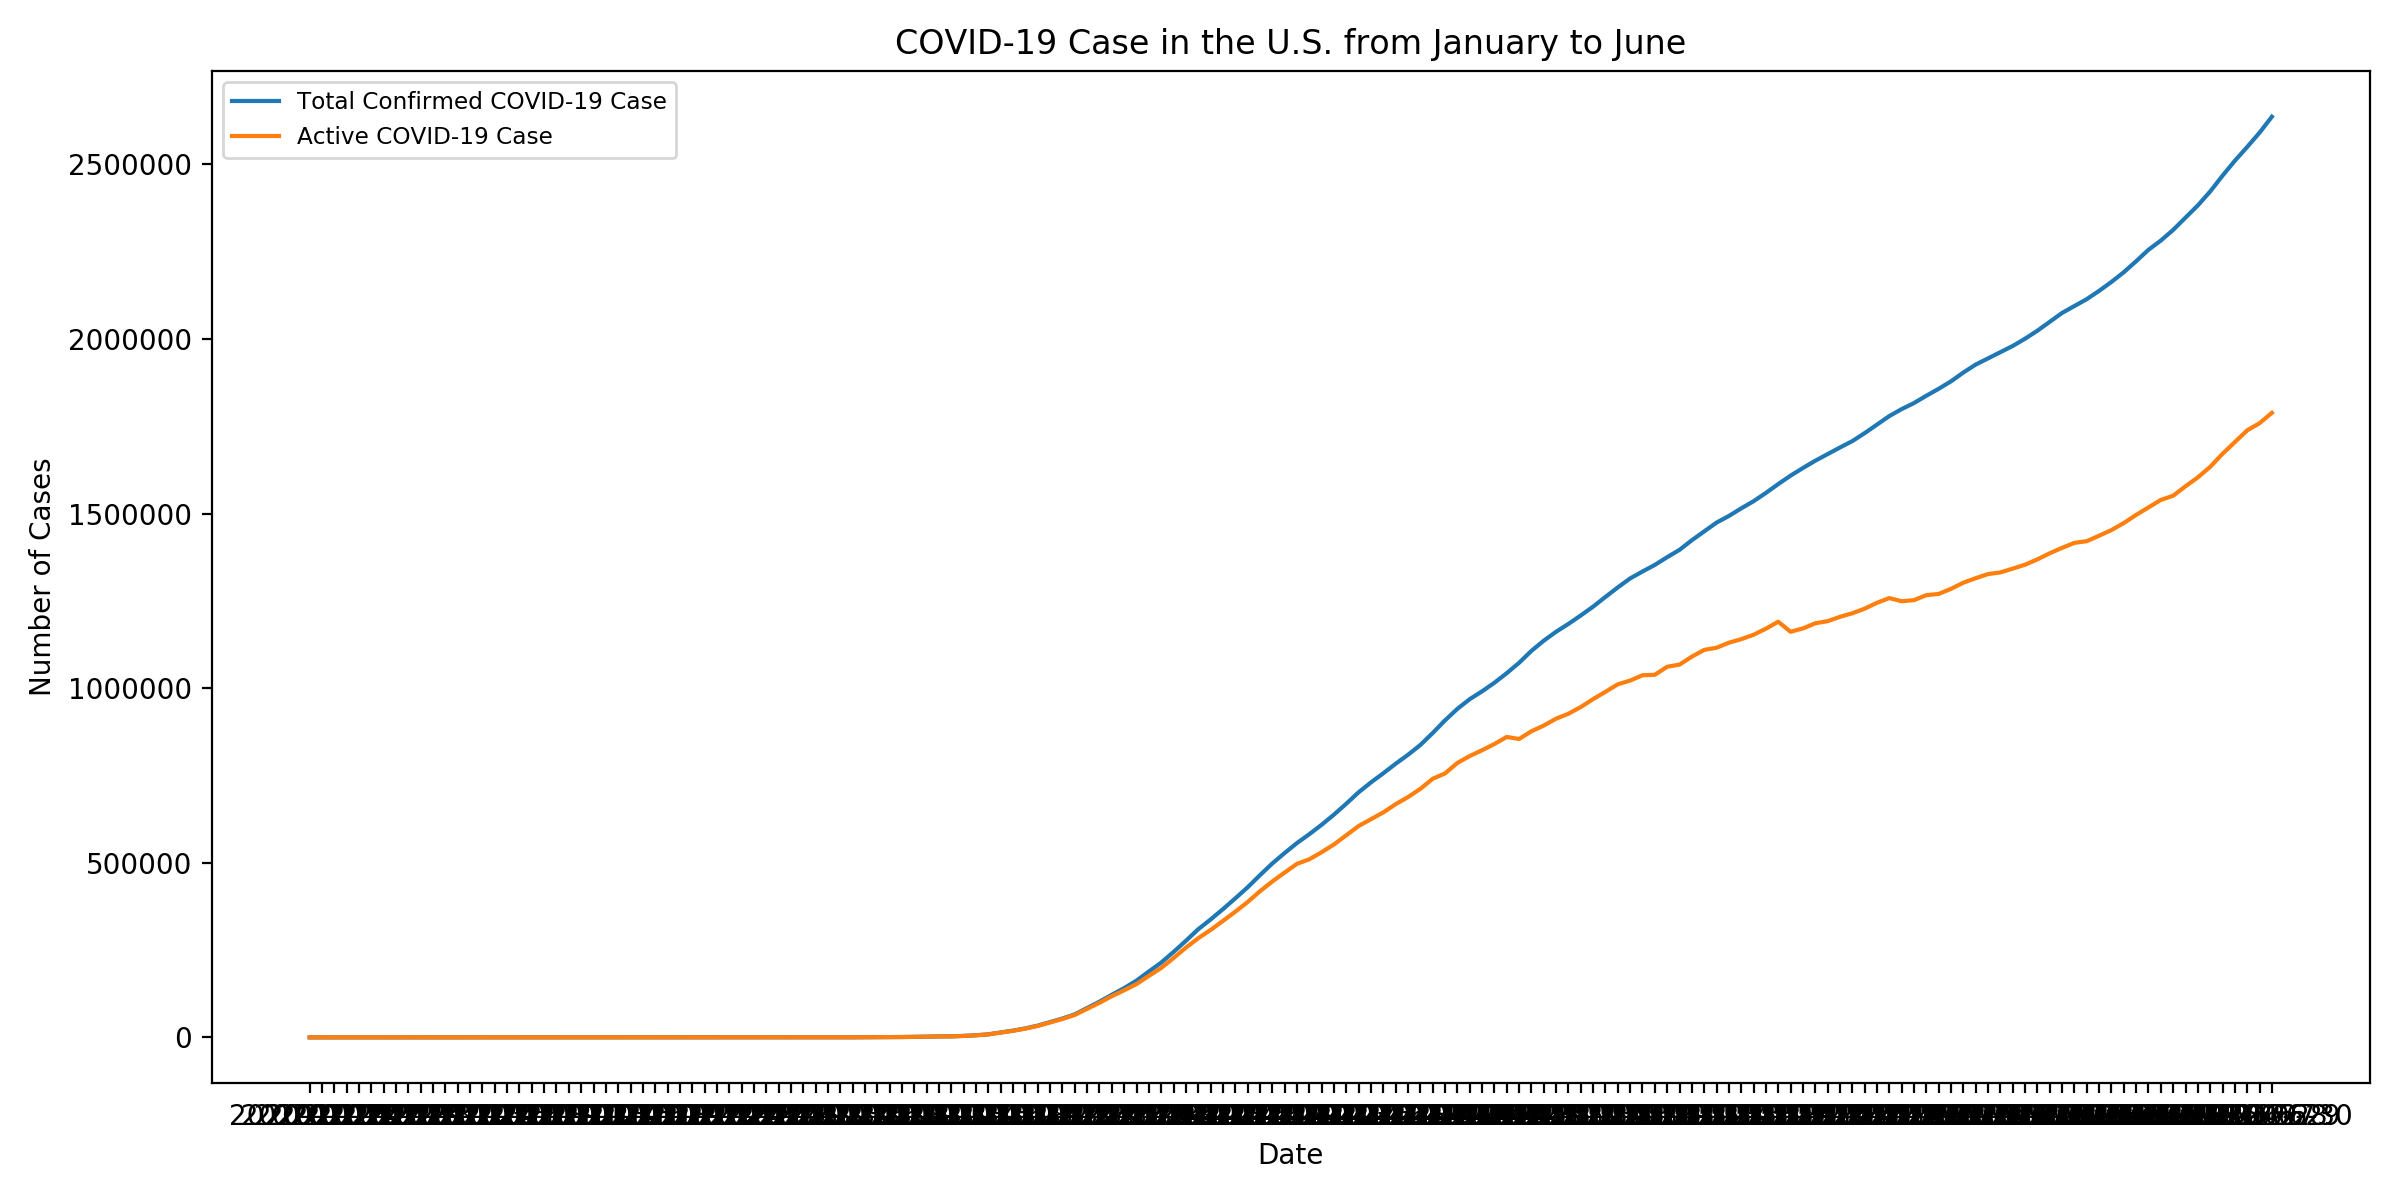

In [144]:
us_confirmed =plt.plot( us_case['Date'], us_case['Confirmed'], label="Total Confirmed COVID-19 Case" )
plt.title("COVID-19 Case in the U.S. from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")
plt.show() 

us_active = plt.plot( us_case['Date'], us_case['Active'], label="Active COVID-19 Case" )
plt.title("COVID-19 Case in the U.S. from January to June")
plt.xlabel("Date")
plt.ylabel("Number of Cases")

plt.legend(loc="best", fontsize="small", fancybox=True)
plt.tight_layout()
plt.savefig("../images/covid_us.png")
plt.show()

In [145]:
# Save our graph and show the grap
#plt.tight_layout()
#plt.savefig("../Images/avg_state_rain.png")
#plt.show()

In [146]:
### BEGIN Airport Data retrieval & clean ###

In [147]:
#Airport Data 2016
airport_data_2016 = '../project_data/airline_data/TFMSC_Report_2016.csv'
df = pd.read_csv(airport_data_2016)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2016_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2016_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2016,ATL - Atlanta,US to Foreign,9,"2,975"
1,1/1/2016,ATL - Atlanta,US to Foreign,1,550
2,1/1/2016,ATL - Atlanta,US to Foreign,1,0
3,1/1/2016,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2016,ATL - Atlanta,US to Foreign,5,"1,225"


In [148]:
#Airport Data 2017
airport_data_2017 = '../project_data/airline_data/TFMSC_Report_2017.csv'
df = pd.read_csv(airport_data_2017)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2017_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2017_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2017,ATL - Atlanta,US to Foreign,8,"2,680"
1,1/1/2017,ATL - Atlanta,US to Foreign,1,335
2,1/1/2017,ATL - Atlanta,US to Foreign,1,364
3,1/1/2017,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2017,ATL - Atlanta,US to Foreign,7,"1,715"


In [149]:
#Airport Data 2018
airport_data_2018 = '../project_data/airline_data/TFMSC_Report_2018.csv'
df = pd.read_csv(airport_data_2018)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2018_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2018_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2018,ATL - Atlanta,US to Foreign,5,"1,675"
1,1/1/2018,ATL - Atlanta,US to Foreign,1,335
2,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,380"
3,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,470"
4,1/1/2018,ATL - Atlanta,US to Foreign,6,"1,775"


In [150]:
#Airport Data 2019
airport_data_2019 = '../project_data/airline_data/TFMSC_Report_2019.csv'
df = pd.read_csv(airport_data_2019)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2019_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2019_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2019,ATL - Atlanta,US to Foreign,5,"1,265"
1,1/1/2019,ATL - Atlanta,US to Foreign,3,"1,005"
2,1/1/2019,ATL - Atlanta,US to Foreign,1,372
3,1/1/2019,ATL - Atlanta,US to Foreign,1,314
4,1/1/2019,ATL - Atlanta,US to Foreign,1,416


In [151]:
#Airport Data 2020
airport_data_2020 = '../project_data/airline_data/TFMSC_Report_2020.csv'
df = pd.read_csv(airport_data_2020)
new_df = df.dropna()
new_df

#grouped_df = new_df.groupby(['Airport'])
#grouped_df.head()

cleaned_2020_df = new_df[['Date','Airport','Flight Type','Departures','Departure Seats']]
cleaned_2020_df.head()

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2020,ATL - Atlanta,US to Foreign,2,506
1,1/1/2020,ATL - Atlanta,US to Foreign,5,"1,635"
2,1/1/2020,ATL - Atlanta,US to Foreign,1,372
3,1/1/2020,ATL - Atlanta,US to Foreign,2,628
4,1/1/2020,ATL - Atlanta,US to Foreign,1,480


In [152]:
#Combined Data for Airports
combined_airport = pd.concat([cleaned_2016_df,cleaned_2017_df,cleaned_2018_df,cleaned_2019_df,cleaned_2020_df])
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,1/1/2016,ATL - Atlanta,US to Foreign,9,"2,975"
1,1/1/2016,ATL - Atlanta,US to Foreign,1,550
2,1/1/2016,ATL - Atlanta,US to Foreign,1,0
3,1/1/2016,ATL - Atlanta,US to Foreign,7,"1,610"
4,1/1/2016,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,7/1/2020,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,7/1/2020,JFK - New York,Domestic,0,0
37361,7/1/2020,JFK - New York,Domestic,0,0
37362,7/1/2020,ORD - Chicago,Domestic,0,0


In [153]:
###BEGIN JAYDEN'S work on feb17 vs feb18 flight data###

In [154]:
#FLU AIRPORT DATA#
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975"
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610"
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,2020-07-01,JFK - New York,Domestic,0,0
37361,2020-07-01,JFK - New York,Domestic,0,0
37362,2020-07-01,ORD - Chicago,Domestic,0,0


In [155]:
#February 2017 Flight Data
start_2017 = '02-01-2017'
end_2017 = '02-28-2017'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2017) & (combined_airport['Date'] <= end_2017)

#Create dataframe for February 2017 flights
february_airport_2017 = pd.DataFrame
february_airport_2017 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ATL - Atlanta']
total_atl_flights_2017 = atlanta_flights['Departures'].sum()
print(total_atl_flights_2017)

#Total Departures for Dallas
dallas_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2017 = dallas_flights['Departures'].sum()
print(total_dallas_flights_2017)

#Total Departures for New York
newyork_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'JFK - New York']
total_newyork_flights_2017 = newyork_flights['Departures'].sum()
print(total_newyork_flights_2017)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2017 = losangeles_flights['Departures'].sum()
print(total_losangeles_flights_2017)

#Total Departures for Chicago
chicago_flights = february_airport_2017.loc[february_airport_2017['Airport'] == 'ORD - Chicago']
total_chicago_flights_2017 = chicago_flights['Departures'].sum()
print(total_chicago_flights_2017)

30481
19751
14669
22291
27346


In [156]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2017,total_dallas_flights_2017,total_newyork_flights_2017,total_losangeles_flights_2017,total_chicago_flights_2017]
total_departures_2017 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2017

,Airport,Departures
0,Atlanta,30481
1,Dallas/Ft. Worth,19751
2,New York,14669
3,Los Angeles,22291
4,Chicago,27346


In [157]:
#March 2018 Flight Data
combined_airport
start_2018 = '02-01-2018'
end_2018 = '02-28-2018'
mask = (combined_airport['Date'] > start_2018) & (combined_airport['Date'] <= end_2018)
february_airport_2018 = pd.DataFrame
february_airport_2018 = combined_airport.loc[mask]
#february_airport_2018.groupby(['Airport'])
#february_airport_2018.head()

# Total Departures for Atlanta
atlanta_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ATL - Atlanta']
total_atl_flights_2018 = atlanta_flights['Departures'].sum()
print(total_atl_flights_2018)

#Total Departures for Dallas
dallas_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2018 = dallas_flights['Departures'].sum()
print(total_dallas_flights_2018)

#Total Departures for New York
newyork_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'JFK - New York']
total_newyork_flights_2018 = newyork_flights['Departures'].sum()
print(total_newyork_flights_2018)

#Total Departures for Los Angeles
losangeles_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2018 = losangeles_flights['Departures'].sum()
print(total_losangeles_flights_2018)

#Total Departures for Chicago
chicago_flights = february_airport_2018.loc[february_airport_2018['Airport'] == 'ORD - Chicago']
total_chicago_flights_2018 = chicago_flights['Departures'].sum()
print(total_chicago_flights_2018)

28319
19524
13044
22878
25727


In [158]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights_2018,total_dallas_flights_2018,total_newyork_flights_2018,total_losangeles_flights_2018,total_chicago_flights_2018]
total_departures_2018 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2018

,Airport,Departures
0,Atlanta,28319
1,Dallas/Ft. Worth,19524
2,New York,13044
3,Los Angeles,22878
4,Chicago,25727


<IPython.core.display.Javascript object>


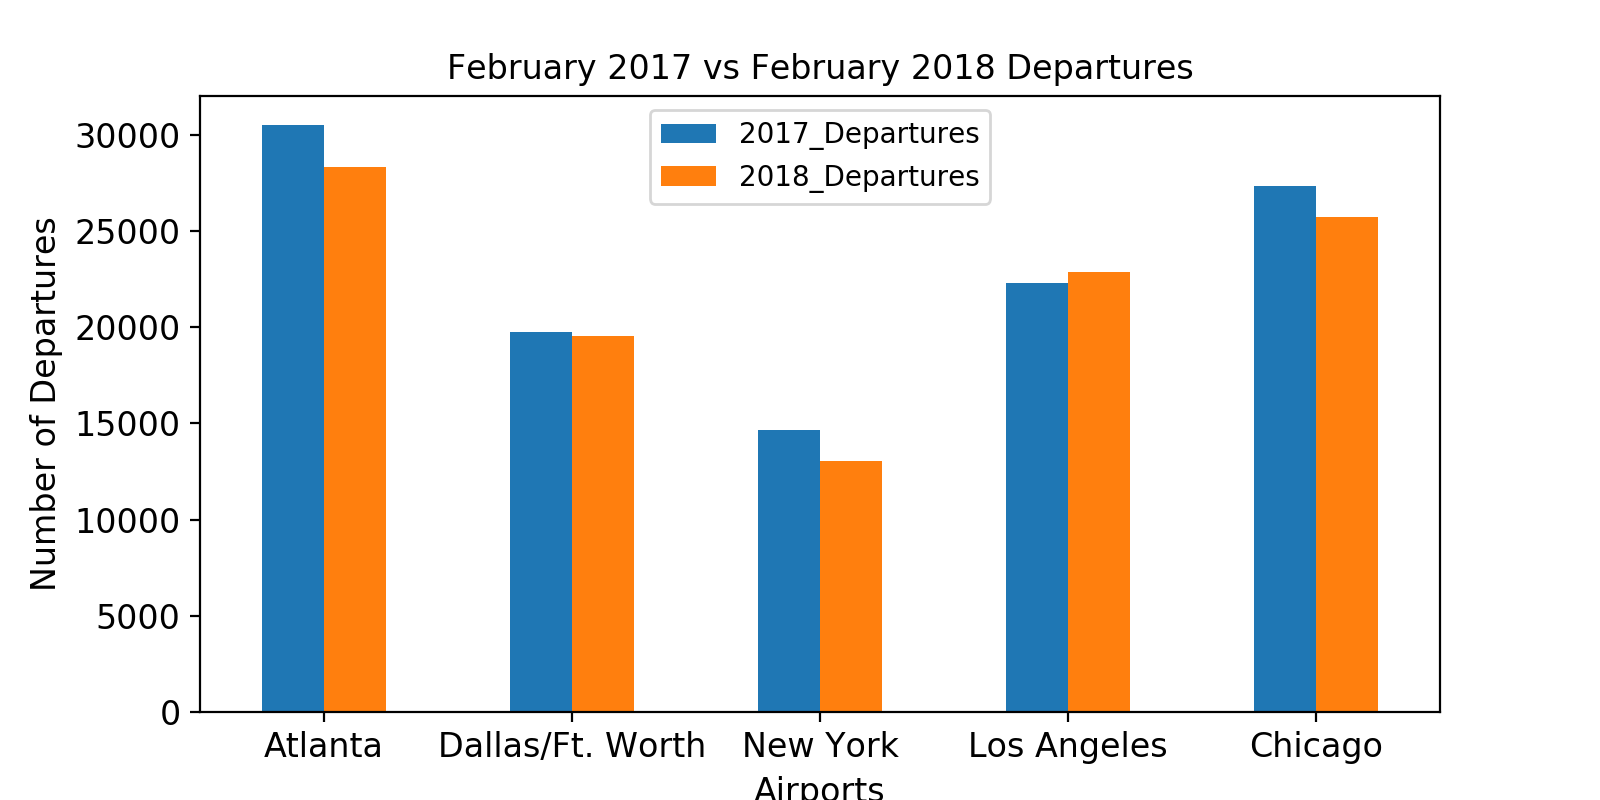

In [159]:
#Merge 2017 and 2018 to create comparison bar graphs
merged_february_departures = pd.merge(total_departures_2017,total_departures_2018, how = 'inner', on='Airport')
merged_february_departures

#rename departure columns
merged_february_departures.rename(columns={'Departures_x': '2017_Departures','Departures_y':'2018_Departures'}, inplace = True)
indexed_february_departures = merged_february_departures.set_index('Airport')
indexed_february_departures
final_february_departure = indexed_february_departures[['2017_Departures','2018_Departures']].plot(kind= 'bar',title = 'February 2017 vs February 2018 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_february_departure.set_xlabel('Airports', fontsize =12)
final_february_departure.set_ylabel('Number of Departures', fontsize=12)
#Save Bar graph to file
plt.savefig("../images/februarydepartures.png")
#Collapse

In [160]:
###BEGIN JAYDEN'S work on mar19 vs mar20 flight data###

In [161]:
#Changed data type to datetime
combined_airport['Date'] = pd.to_datetime(combined_airport['Date'])
combined_airport

#March 2019 Flight Data
start_2019 = '03-01-2019'
end_2019 = '03-31-2019'

#Mask date column to get range of data
mask = (combined_airport['Date'] > start_2019) & (combined_airport['Date'] <= end_2019)

#Create dataframe for March 2019 flights
march_airport_2019 = pd.DataFrame
march_airport_2019 = combined_airport.loc[mask]

# Total Departures for Atlanta
atlanta_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ATL - Atlanta']
total_atl_flights = atlanta_flights['Departures'].sum()
print(total_atl_flights)

#Total Departures for Dallas
dallas_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights = dallas_flights['Departures'].sum()
print(total_dallas_flights)

#Total Departures for New York
newyork_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'JFK - New York']
total_newyork_flights = newyork_flights['Departures'].sum()
print(total_newyork_flights)

#Total Departures for Los Angeles
losangeles_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights = losangeles_flights['Departures'].sum()
print(total_losangeles_flights)

#Total Departures for Chicago
chicago_flights = march_airport_2019.loc[march_airport_2019['Airport'] == 'ORD - Chicago']
total_chicago_flights = chicago_flights['Departures'].sum()
print(total_chicago_flights)

33233
23011
16100
26053
31335


In [162]:
#Dataframe for total Departures for each Airport 
airports = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures = [total_atl_flights,total_dallas_flights,total_newyork_flights,total_losangeles_flights,total_chicago_flights]

total_departures_2019 = pd.DataFrame(list(zip(airports,departures)),columns= ['Airport','Departures'])
total_departures_2019


,Airport,Departures
0,Atlanta,33233
1,Dallas/Ft. Worth,23011
2,New York,16100
3,Los Angeles,26053
4,Chicago,31335


In [163]:
#March 2020 Flight Data
combined_airport

start_2020 = '03-01-2020'
end_2020 = '03-31-2020'

mask = (combined_airport['Date'] > start_2020) & (combined_airport['Date'] <= end_2020)

march_airport_2020 = pd.DataFrame
march_airport_2020 = combined_airport.loc[mask]

march_airport_2020.groupby(['Airport'])
march_airport_2020.head()

,Date,Airport,Flight Type,Departures,Departure Seats
15171,2020-03-02,ATL - Atlanta,US to Foreign,1,253
15172,2020-03-02,ATL - Atlanta,US to Foreign,6,"2,010"
15173,2020-03-02,ATL - Atlanta,US to Foreign,1,335
15174,2020-03-02,ATL - Atlanta,US to Foreign,2,628
15175,2020-03-02,ATL - Atlanta,US to Foreign,1,0


In [164]:
# Total Departures for Atlanta
atlanta_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ATL - Atlanta']
total_atl_flights_2020 = atlanta_flights_2020['Departures'].sum()
print(total_atl_flights_2020)

#Total Departures for Dallas
dallas_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'DFW - Dallas/Ft. Worth']
total_dallas_flights_2020 = dallas_flights_2020['Departures'].sum()
print(total_dallas_flights_2020)

#Total Departures for New York
newyork_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'JFK - New York']
total_newyork_flights_2020 = newyork_flights_2020['Departures'].sum()
print(total_newyork_flights_2020)

#Total Departures for Los Angeles
losangeles_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'LAX - Los Angeles']
total_losangeles_flights_2020 = losangeles_flights_2020['Departures'].sum()
print(total_losangeles_flights_2020)

#Total Departures for Chicago
chicago_flights_2020 = march_airport_2020.loc[march_airport_2020['Airport'] == 'ORD - Chicago']
total_chicago_flights_2020 = chicago_flights_2020['Departures'].sum()
print(total_chicago_flights_2020)

25124
20220
11492
20670
27345


In [165]:
#Dataframe for total Departures for each Airport 
airports_2020 = ['Atlanta','Dallas/Ft. Worth','New York','Los Angeles','Chicago']
departures_2020 = [total_atl_flights_2020,total_dallas_flights_2020,total_newyork_flights_2020,total_losangeles_flights_2020,total_chicago_flights_2020]

total_departures_2020 = pd.DataFrame(list(zip(airports_2020,departures_2020)),columns= ['Airport','Departures'])
total_departures_2020


,Airport,Departures
0,Atlanta,25124
1,Dallas/Ft. Worth,20220
2,New York,11492
3,Los Angeles,20670
4,Chicago,27345


In [166]:
#Merge 2019 and 2020 to create comparison bar graphs
merged_march_departures = pd.merge(total_departures_2019,total_departures_2020, how = 'inner', on='Airport')
merged_march_departures

#rename departure columns
merged_march_departures.rename(columns={'Departures_x': '2019_Departures','Departures_y':'2020_Departures'}, inplace = True)
indexed_march_departures = merged_march_departures.set_index('Airport')

indexed_march_departures

,2019_Departures,2020_Departures
Airport,,
Atlanta,33233,25124
Dallas/Ft. Worth,23011,20220
New York,16100,11492
Los Angeles,26053,20670
Chicago,31335,27345


<IPython.core.display.Javascript object>


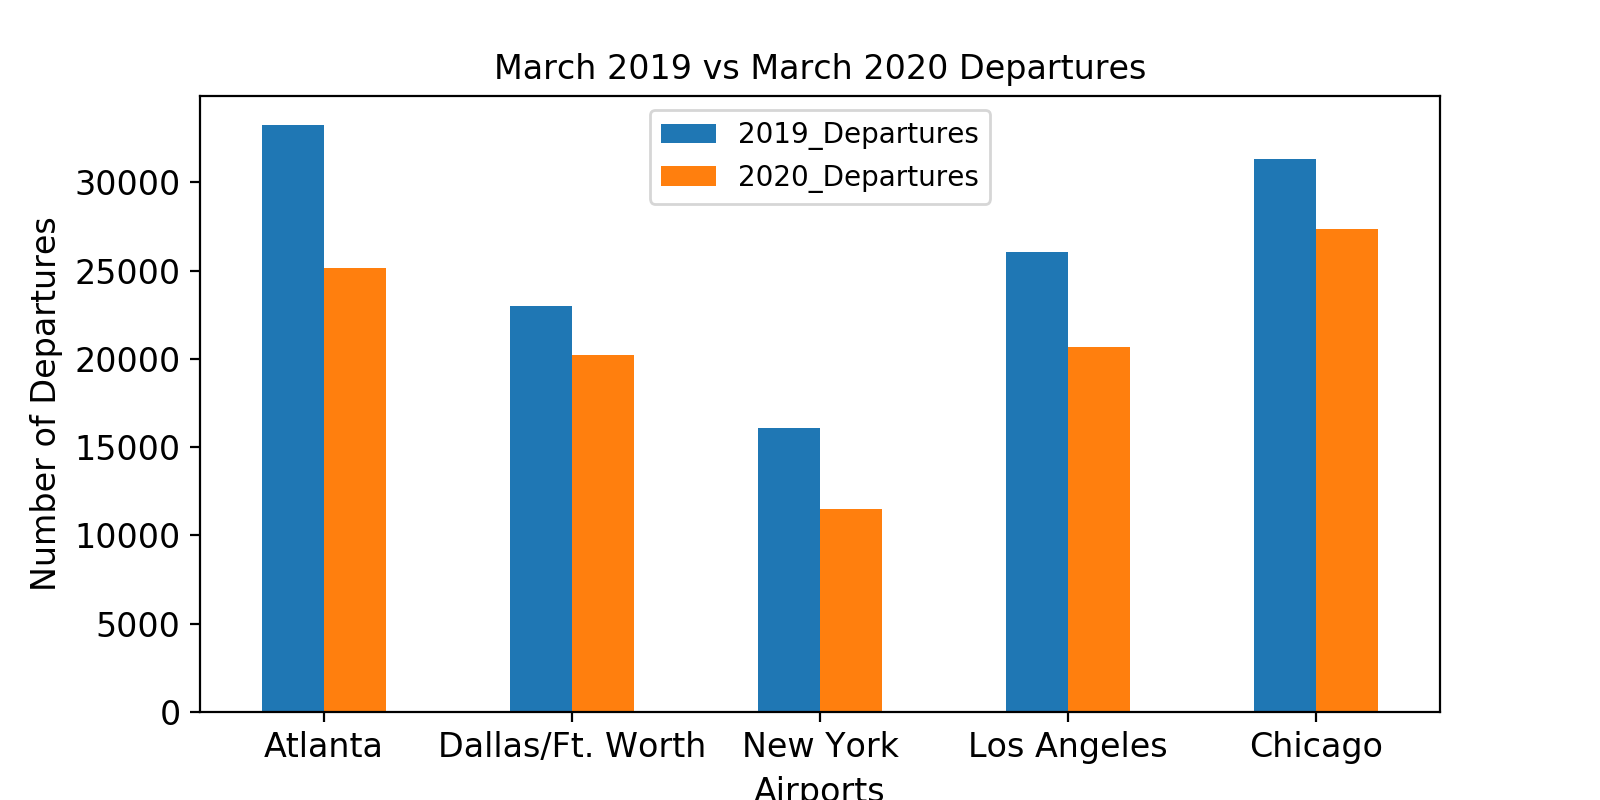

In [167]:
final_march_departure = indexed_march_departures[['2019_Departures','2020_Departures']].plot(kind= 'bar',title = 'March 2019 vs March 2020 Departures', figsize = (8,4),legend = True, fontsize =12, rot=0)
final_march_departure.set_xlabel('Airports', fontsize =12)
final_march_departure.set_ylabel('Number of Departures', fontsize=12)

#Save Bar grpah to file
plt.savefig("../images/marchdepartures.png")

In [168]:
###Begin Max&Danny&Dave's work on Departure Seats calculation for all 5 years

In [169]:
#display combined_airport df
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975"
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610"
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225"
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0
37360,2020-07-01,JFK - New York,Domestic,0,0
37361,2020-07-01,JFK - New York,Domestic,0,0
37362,2020-07-01,ORD - Chicago,Domestic,0,0


In [170]:
#Change Date to datetime
combined_airport['month'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.month
combined_airport['year'] = pd.to_datetime(combined_airport['Date'], format='%m/%d/%Y').dt.year
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2016-01-01,ATL - Atlanta,US to Foreign,9,"2,975",1,2016
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550,1,2016
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0,1,2016
3,2016-01-01,ATL - Atlanta,US to Foreign,7,"1,610",1,2016
4,2016-01-01,ATL - Atlanta,US to Foreign,5,"1,225",1,2016
...,...,...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0,7,2020
37360,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37361,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37362,2020-07-01,ORD - Chicago,Domestic,0,0,7,2020


In [171]:
#Change Data Type for Departure Seats in combined_airport to Integer
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(str) 
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].str.replace(',', '')
combined_airport["Departure Seats"] = combined_airport["Departure Seats"].astype(int)
combined_airport.dtypes

Date               datetime64[ns]
Airport                    object
Flight Type                object
Departures                  int64
Departure Seats             int64
month                       int64
year                        int64
dtype: object

<IPython.core.display.Javascript object>


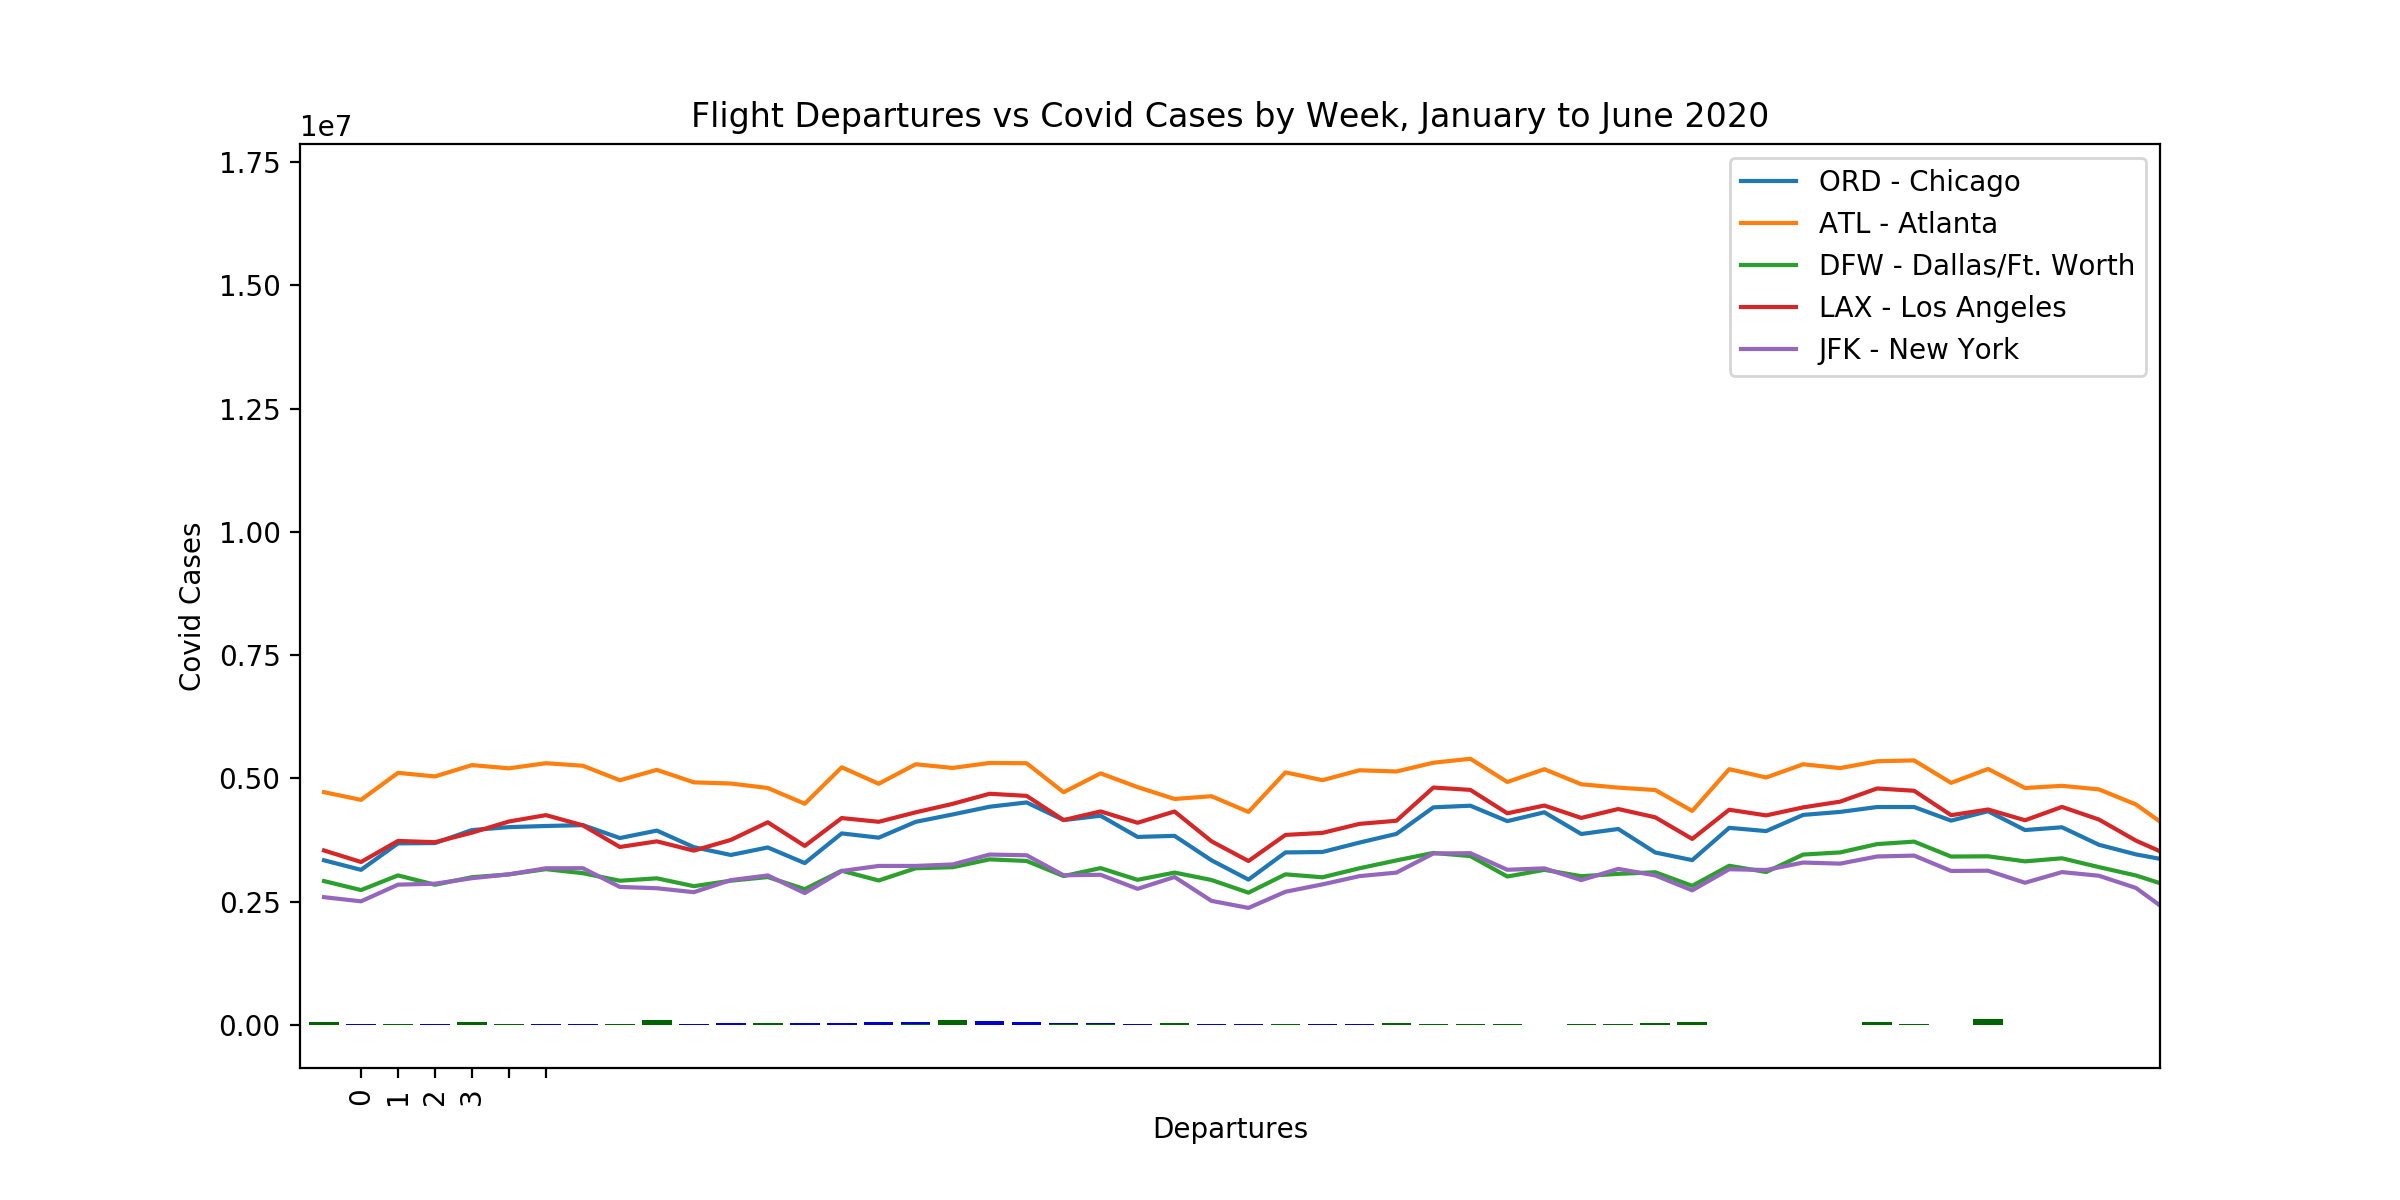

In [172]:
import matplotlib.pyplot as plt
# Used for combining year-month
date_group = []
# Self explains
airport_names = ["ORD - Chicago",
                 "ATL - Atlanta",
                 "DFW - Dallas/Ft. Worth",
                 "LAX - Los Angeles",
                 "JFK - New York"]
# The group by used to sum departures
gp = combined_airport.groupby(['Airport','year','month'])
airport_all = gp.sum()
#print(airport_all)
# concatenating the multiindex year and month column into one
for i in airport_all.index:
    date_group.append(str(i[1]) + "-" + str(i[2]))
# Creating the x axis values used to display the time series
airport_all["date_group"] = date_group
# Drop the index
airport_all.droplevel(['year', 'month'])
# Conjutes the canvas used to draw the graphs
fig, ax = plt.subplots()
# Iterate over airports and draws a time series for each
for airport in airport_names:
    df = airport_all.loc[airport,["Departure Seats", "date_group"]]
    line, = ax.plot(df["date_group"], df["Departure Seats"], label = airport)
plt.xticks(rotation=90)
plt.xlabel("Year & Month")
plt.ylabel("Departure Seats")
ax.legend()
#plt.rcParams['figure.figsize'] = (16,8)
plt.title("Best Graph Ever")
plt.savefig("../images/departseats_all.png")
plt.show()

In [216]:
airport_all


Departures  Departure Seats date_group
Airport       year month                                        
ATL - Atlanta 2016 1           33967          4721288     2016-1
                   2           32817          4565503     2016-2
                   3           37384          5113037     2016-3
                   4           36484          5040392     2016-4
                   5           37581          5270190     2016-5
...                              ...              ...        ...
ORD - Chicago 2020 3           28412          3321530     2020-3
                   4           10663          1228589     2020-4
                   5            9568          1156947     2020-5
                   6           10239          1267298     2020-6
                   7               0                0     2020-7

[274 rows x 3 columns]

In [173]:
### BEGIN DAVE's code below for 2017-18 flu ###
# import and clean data from CDC FluView website csv download

In [174]:
# define data file
flu_state = "../project_data/flu_data/State_ILINet.csv"

In [175]:
# read data file
raw_state_flu_2017 = pd.read_csv(flu_state)

In [176]:
raw_state_flu_2017.head(15)

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS
0,States,Alabama,2017,40,X,1.75721,X,X,X,X,X,X,698,85,39722
1,States,Alaska,2017,40,X,2.72675,X,X,X,X,X,X,141,17,5171
2,States,Arizona,2017,40,X,2.3554,X,X,X,X,X,X,406,42,17237
3,States,Arkansas,2017,40,X,0.812294,X,X,X,X,X,X,37,17,4555
4,States,California,2017,40,X,1.75421,X,X,X,X,X,X,852,102,48569
5,States,Colorado,2017,40,X,0.561578,X,X,X,X,X,X,129,42,22971
6,States,Connecticut,2017,40,X,1.04416,X,X,X,X,X,X,48,17,4597
7,States,Delaware,2017,40,X,0.0717875,X,X,X,X,X,X,2,13,2786
8,States,District of Columbia,2017,40,X,1.91672,X,X,X,X,X,X,284,5,14817
9,States,Florida,2017,40,X,X,X,X,X,X,X,X,X,X,X


In [177]:
# create datetime column from year and week 
raw_state_flu_2017['formatted_date'] = raw_state_flu_2017.YEAR * 1000 + raw_state_flu_2017.WEEK * 10
raw_state_flu_2017['date'] = pd.to_datetime(raw_state_flu_2017['formatted_date'], format='%Y%W%w')
raw_state_flu_2017.head()

,REGION TYPE,REGION,YEAR,WEEK,% WEIGHTED ILI,%UNWEIGHTED ILI,AGE 0-4,AGE 25-49,AGE 25-64,AGE 5-24,AGE 50-64,AGE 65,ILITOTAL,NUM. OF PROVIDERS,TOTAL PATIENTS,formatted_date,date
0,States,Alabama,2017,40,X,1.75721,X,X,X,X,X,X,698,85,39722,2017400,2017-10-08
1,States,Alaska,2017,40,X,2.72675,X,X,X,X,X,X,141,17,5171,2017400,2017-10-08
2,States,Arizona,2017,40,X,2.3554,X,X,X,X,X,X,406,42,17237,2017400,2017-10-08
3,States,Arkansas,2017,40,X,0.812294,X,X,X,X,X,X,37,17,4555,2017400,2017-10-08
4,States,California,2017,40,X,1.75421,X,X,X,X,X,X,852,102,48569,2017400,2017-10-08


In [178]:
# collect a list of all columns within the DataFrame
raw_state_flu_2017.columns

Index(['REGION TYPE', 'REGION', 'YEAR', 'WEEK', '% WEIGHTED ILI',
       '%UNWEIGHTED ILI', 'AGE 0-4', 'AGE 25-49', 'AGE 25-64', 'AGE 5-24',
       'AGE 50-64', 'AGE 65', 'ILITOTAL', 'NUM. OF PROVIDERS',
       'TOTAL PATIENTS', 'formatted_date', 'date'],
      dtype='object')

In [179]:
# extract required columns to new DataFrame
temp_state_flu_2017 = raw_state_flu_2017[['REGION', 'YEAR', 'WEEK', 'date', 'ILITOTAL']]
temp_state_flu_2017.head()

,REGION,YEAR,WEEK,date,ILITOTAL
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852


In [180]:
# drop rows with "X" in ILITOTAL column
temp_state_flu_2017 = temp_state_flu_2017[temp_state_flu_2017.ILITOTAL != 'X']
temp_state_flu_2017.head(15)

,REGION,YEAR,WEEK,date,ILITOTAL
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852
5,Colorado,2017,40,2017-10-08,129
6,Connecticut,2017,40,2017-10-08,48
7,Delaware,2017,40,2017-10-08,2
8,District of Columbia,2017,40,2017-10-08,284
10,Georgia,2017,40,2017-10-08,850


In [181]:
#check data types
temp_state_flu_2017.dtypes

REGION              object
YEAR                 int64
WEEK                 int64
date        datetime64[ns]
ILITOTAL            object
dtype: object

In [182]:
# identify incomplete rows
temp_state_flu_2017.count()

REGION      2600
YEAR        2600
WEEK        2600
date        2600
ILITOTAL    2600
dtype: int64

In [183]:
# use pd.to_numeric() method to convert the datatype of the ILITOTAL column
temp_state_flu_2017['ILITOTAL'] = pd.to_numeric(temp_state_flu_2017['ILITOTAL'])
temp_state_flu_2017['ILITOTAL'].dtype

dtype('int64')

In [184]:
# rename the columns     
clean_state_flu_2017 = temp_state_flu_2017.rename(columns={"REGION":"State",
                                                           "YEAR":"Year",
                                                           "WEEK":"Week",
                                                           "date":"Week Ending Date",
                                                           "ILITOTAL":"ILI Cases"})
clean_state_flu_2017.head()

,State,Year,Week,Week Ending Date,ILI Cases
0,Alabama,2017,40,2017-10-08,698
1,Alaska,2017,40,2017-10-08,141
2,Arizona,2017,40,2017-10-08,406
3,Arkansas,2017,40,2017-10-08,37
4,California,2017,40,2017-10-08,852


In [185]:
# determine the total number of ILI Cases
total_cases = clean_state_flu_2017["ILI Cases"].sum()
total_cases

1085870

In [186]:
# determine the total of all ILI Cases by week
ILI_by_week = clean_state_flu_2017.groupby(['Week Ending Date']).sum()['ILI Cases']
ILI_by_week

Week Ending Date
2017-10-08    11343
2017-10-15    11585
2017-10-22    12400
2017-10-29    13721
2017-11-05    14932
2017-11-12    16877
2017-11-19    19061
2017-11-26    17474
2017-12-03    21453
2017-12-10    21936
2017-12-17    28435
2017-12-24    39147
2017-12-31    41383
2018-01-07    43428
2018-01-14    51481
2018-01-21    56161
2018-01-28    68029
2018-02-04    75649
2018-02-11    76307
2018-02-18    66326
2018-02-25    45937
2018-03-04    32349
2018-03-11    25973
2018-03-18    23097
2018-03-25    21085
2018-04-01    18100
2018-04-08    16919
2018-04-15    14649
2018-04-22    13075
2018-04-29    12647
2018-05-06    11330
2018-05-13     9730
2018-05-20     9259
2018-05-27     8730
2018-06-03     8015
2018-06-10     6931
2018-06-17     5931
2018-06-24     5918
2018-07-01     5655
2018-07-08     5122
2018-07-15     5301
2018-07-22     4640
2018-07-29     4534
2018-08-05     4533
2018-08-12     4742
2018-08-19     5424
2018-08-26     6220
2018-09-02     6967
2018-09-09     8272
201

In [187]:
type(ILI_by_week)

pandas.core.series.Series

In [188]:
# count how many ILI cases have occured within each state
ILI_by_state = clean_state_flu_2017.groupby('State').sum()['ILI Cases']
ILI_by_state.head()

State
Alabama       67520
Alaska         9203
Arizona       25945
Arkansas       6302
California    55499
Name: ILI Cases, dtype: int64

In [189]:
type(ILI_by_state)

pandas.core.series.Series

In [190]:
# determine the total of all ILI Cases by week per state
ILI_by_state_by_week = clean_state_flu_2017.groupby(['State', 'Week Ending Date']).sum()['ILI Cases']
ILI_by_state_by_week.head(15)

State    Week Ending Date
Alabama  2017-10-08           698
         2017-10-15           738
         2017-10-22           710
         2017-10-29           799
         2017-11-05           979
         2017-11-12           964
         2017-11-19          1100
         2017-11-26           967
         2017-12-03          1239
         2017-12-10          1274
         2017-12-17          1737
         2017-12-24          3116
         2017-12-31          3583
         2018-01-07          3738
         2018-01-14          4829
Name: ILI Cases, dtype: int64

In [191]:
type(ILI_by_state_by_week)

pandas.core.series.Series

In [192]:
# create a bar chart from the series
ILI_by_week.plot.bar(x='Week Ending Date', y=ILI_by_week, color='mediumblue', align="center", width=0.8)

# Method 1
#fig, ax = plt.subplots()
#loc = WeekdayLocator(byweekday=SU, interval=4, tz=None)
#ax.xaxis.set_major_locator(loc)

# Method 2
def apply_date_formatting_to_axis(ax):
    # format x-axis of input plot to a readable date format
    dates = ['Week Ending Date']
    ax.xaxis.set_major_locator(dates.WeekdayLocator(byweekday=SU, interval=4))
    #ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n%a'))
    #ax.xaxis.grid(True, which="minor")
    #ax.yaxis.grid()
    return ax 

# Method 3
# tell matplotlib which x axis labels to display
# for i, t in enumerate(['Week Ending Date'].get_xlabel()):
#     if (i % 5) != 0:
#         t.set_visible(False)

# give the chart some labels and a title
plt.title("2017-18 USA Flu Season Positive Lab Test Results")
plt.xlabel("Week Ending Date")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_week.png")
plt.show()

In [193]:
# create a bar chart from the series
ILI_by_state.plot.bar(x='Week Ending Date', y=ILI_by_state, color='darkgreen', align="center", width=0.8)

# give the chart some labels and a title
plt.title("2017-18 Flu Season Positive Lab Test Results by State")
plt.xlabel("State")
plt.ylabel("Number of Influenza-Like-Infections (ILI)")

# change figure size
plt.rcParams['figure.figsize'] = (12,6)

# save an image of the chart and print it to the screen
plt.savefig("../images/flu_by_state.png")
plt.show()

In [194]:
###Part Three###

In [195]:
###BEGIN DANNY & DAVE & MAX's Work on CORRELATION GRAPHS

#display df
combined_airport

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2016-01-01,ATL - Atlanta,US to Foreign,9,2975,1,2016
1,2016-01-01,ATL - Atlanta,US to Foreign,1,550,1,2016
2,2016-01-01,ATL - Atlanta,US to Foreign,1,0,1,2016
3,2016-01-01,ATL - Atlanta,US to Foreign,7,1610,1,2016
4,2016-01-01,ATL - Atlanta,US to Foreign,5,1225,1,2016
...,...,...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,0,7,2020
37360,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37361,2020-07-01,JFK - New York,Domestic,0,0,7,2020
37362,2020-07-01,ORD - Chicago,Domestic,0,0,7,2020


In [196]:
#build df with jan to june
start_2018 = '01-01-2018'
end_2018 = '06-30-2018'

#mask date column
mask = (combined_airport["Date"] >= start_2018) & (combined_airport["Date"] <= end_2018)

flu_dates = pd.DataFrame()
flu_dates = combined_airport.loc[mask]
flu_dates

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2018-01-01,ATL - Atlanta,US to Foreign,5,1675,1,2018
1,2018-01-01,ATL - Atlanta,US to Foreign,1,335,1,2018
2,2018-01-01,ATL - Atlanta,US to Foreign,6,1380,1,2018
3,2018-01-01,ATL - Atlanta,US to Foreign,6,1470,1,2018
4,2018-01-01,ATL - Atlanta,US to Foreign,6,1775,1,2018
...,...,...,...,...,...,...,...
45162,2018-06-30,ORD - Chicago,Domestic,1,90,6,2018
45163,2018-06-30,ORD - Chicago,Domestic,74,3700,6,2018
45164,2018-06-30,ORD - Chicago,Domestic,55,3850,6,2018
45165,2018-06-30,ORD - Chicago,Domestic,5,450,6,2018


In [197]:
#extract date and departures into new df, then pull covid data into this dataframe.
airline_week_total = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]
airline_week_total

#grouping by date
airline_week_total.groupby(["Date"])

In [198]:
airline_week_total["Air Week"] = airline_week_total["Date"].dt.week
airline_week_total

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Date,Airport,Flight Type,Departures,Air Week
0,2016-01-01,ATL - Atlanta,US to Foreign,9,53
1,2016-01-01,ATL - Atlanta,US to Foreign,1,53
2,2016-01-01,ATL - Atlanta,US to Foreign,1,53
3,2016-01-01,ATL - Atlanta,US to Foreign,7,53
4,2016-01-01,ATL - Atlanta,US to Foreign,5,53
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,27
37360,2020-07-01,JFK - New York,Domestic,0,27
37361,2020-07-01,JFK - New York,Domestic,0,27
37362,2020-07-01,ORD - Chicago,Domestic,0,27


In [199]:
#flu main df's data types:
clean_state_flu_2017.dtypes

State                       object
Year                         int64
Week                         int64
Week Ending Date    datetime64[ns]
ILI Cases                    int64
dtype: object

In [200]:
#new df with mask for flu data 
wkstart = 1
wkend = 26
mask_flu = (clean_state_flu_2017["Week"] >= wkstart) & (clean_state_flu_2017["Week"] <= wkend)

flu_wk = pd.DataFrame()
flu_wk = clean_state_flu_2017.loc[mask_flu]
flu_wk

,State,Year,Week,Week Ending Date,ILI Cases
663,Alabama,2018,1,2018-01-07,3738
664,Alaska,2018,1,2018-01-07,222
665,Arizona,2018,1,2018-01-07,1249
666,Arkansas,2018,1,2018-01-07,257
667,California,2018,1,2018-01-07,2310
...,...,...,...,...,...
1984,Virginia,2018,26,2018-07-01,767
1985,Washington,2018,26,2018-07-01,19
1986,West Virginia,2018,26,2018-07-01,6
1987,Wisconsin,2018,26,2018-07-01,1


In [201]:
#new df with mask for airline data 
wkstart = 1
wkend = 26
mask_air = (airline_week_total["Air Week"] >= wkstart) & (airline_week_total["Air Week"] <= wkend)

air_wk = pd.DataFrame()
air_wk = airline_week_total.loc[mask_air]
air_wk

,Date,Airport,Flight Type,Departures,Air Week
716,2016-01-04,ATL - Atlanta,US to Foreign,1,1
717,2016-01-04,ATL - Atlanta,US to Foreign,8,1
718,2016-01-04,ATL - Atlanta,US to Foreign,1,1
719,2016-01-04,ATL - Atlanta,US to Foreign,1,1
720,2016-01-04,ATL - Atlanta,US to Foreign,1,1
...,...,...,...,...,...
37016,2020-06-28,ORD - Chicago,Domestic,16,26
37017,2020-06-28,ORD - Chicago,Domestic,46,26
37018,2020-06-28,ORD - Chicago,Domestic,46,26
37019,2020-06-28,ORD - Chicago,Domestic,44,26


In [202]:
#create new df with flu by week & departures by week
flu_final = flu_wk.groupby("Week").sum()["ILI Cases"]
air_final = air_wk.groupby("Air Week").sum()["Departures"]

# Create a DataFrame to hold results
flu_vs_air = pd.DataFrame({"Departures": air_final, 
                           "Flu Cases": flu_final
                          })


flu_vs_air

,Departures,Flu Cases
1,145934,43428
2,144186,51481
3,140686,56161
4,144448,68029
5,140858,75649
6,142126,76307
7,144795,66326
8,148292,45937
9,149635,32349
10,152258,25973


In [203]:
# Calculate the correlation coefficient and linear regression model 
# for flu vs air

corr=round(st.pearsonr(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])[0],2)
print(f"The correlation between flight departures and flu cases is {corr}")
model = st.linregress(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])

y_values = flu_vs_air["Departures"]*model[0]+model[1]
plt.scatter(flu_vs_air["Departures"],flu_vs_air["Flu Cases"])
plt.plot(flu_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Flu Cases")
plt.title("Flight Departures vs Flu Cases by Week, January to June 2018")
plt.savefig("../images/flucorr.png")
plt.show()

The correlation between flight departures and flu cases is 0.44


In [204]:
### Correlation between departures & covid data ###
#display covid for us df:
us_case


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [205]:
#show dtypes for us_case
us_case.dtypes

Date               object
Country/Region     object
Confirmed           int64
Deaths              int64
Recovered         float64
Active            float64
dtype: object

In [206]:
#Change Date to datetime for us_case
us_case['Date'] = pd.to_datetime(us_case['Date'])
us_case

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Country/Region,Confirmed,Deaths,Recovered,Active
362,2020-01-23,US,1,0,0.0,1.0
550,2020-01-24,US,2,0,0.0,2.0
738,2020-01-25,US,2,0,0.0,2.0
926,2020-01-26,US,5,0,0.0,5.0
1114,2020-01-27,US,5,0,0.0,5.0
...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0


In [207]:
#create covid by week column and display
us_case["Covid Week"] = us_case["Date"].dt.week
us_case

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Country/Region,Confirmed,Deaths,Recovered,Active,Covid Week
362,2020-01-23,US,1,0,0.0,1.0,4
550,2020-01-24,US,2,0,0.0,2.0,4
738,2020-01-25,US,2,0,0.0,2.0,4
926,2020-01-26,US,5,0,0.0,5.0,4
1114,2020-01-27,US,5,0,0.0,5.0,5
...,...,...,...,...,...,...,...
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0,26
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0,26
29878,2020-06-28,US,2549864,126361,685164.0,1738339.0,26
30066,2020-06-29,US,2590668,126711,705203.0,1758754.0,27


In [208]:
#new df with mask for covid data 
wkstart = 4
wkend = 26
mask_covid = (us_case["Covid Week"] >= wkstart) & (us_case["Covid Week"] <= wkend)

covid_wk = pd.DataFrame()
covid_wk = us_case.loc[mask_covid]
covid_wk

,Date,Country/Region,Confirmed,Deaths,Recovered,Active,Covid Week
362,2020-01-23,US,1,0,0.0,1.0,4
550,2020-01-24,US,2,0,0.0,2.0,4
738,2020-01-25,US,2,0,0.0,2.0,4
926,2020-01-26,US,5,0,0.0,5.0,4
1114,2020-01-27,US,5,0,0.0,5.0,5
...,...,...,...,...,...,...,...
29126,2020-06-24,US,2382426,122604,656161.0,1603661.0,26
29314,2020-06-25,US,2422299,125026,663562.0,1633711.0,26
29502,2020-06-26,US,2467554,125631,670809.0,1671114.0,26
29690,2020-06-27,US,2510259,126120,679308.0,1704831.0,26


In [209]:
#redisplay air_wk
air_wk

,Date,Airport,Flight Type,Departures,Air Week
716,2016-01-04,ATL - Atlanta,US to Foreign,1,1
717,2016-01-04,ATL - Atlanta,US to Foreign,8,1
718,2016-01-04,ATL - Atlanta,US to Foreign,1,1
719,2016-01-04,ATL - Atlanta,US to Foreign,1,1
720,2016-01-04,ATL - Atlanta,US to Foreign,1,1
...,...,...,...,...,...
37016,2020-06-28,ORD - Chicago,Domestic,16,26
37017,2020-06-28,ORD - Chicago,Domestic,46,26
37018,2020-06-28,ORD - Chicago,Domestic,46,26
37019,2020-06-28,ORD - Chicago,Domestic,44,26


In [210]:
#build df with jan to june 2020 from combined_airport
start_2020 = '01-01-2020'
end_2020 = '06-30-2020'

#mask date column
mask_air = (combined_airport["Date"] >= start_2020) & (combined_airport["Date"] <= end_2020)

air2020_dates = pd.DataFrame()
air2020_dates = combined_airport.loc[mask_air]
air2020_dates

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2020-01-01,ATL - Atlanta,US to Foreign,2,506,1,2020
1,2020-01-01,ATL - Atlanta,US to Foreign,5,1635,1,2020
2,2020-01-01,ATL - Atlanta,US to Foreign,1,372,1,2020
3,2020-01-01,ATL - Atlanta,US to Foreign,2,628,1,2020
4,2020-01-01,ATL - Atlanta,US to Foreign,1,480,1,2020
...,...,...,...,...,...,...,...
37353,2020-06-30,ORD - Chicago,Domestic,38,3268,6,2020
37354,2020-06-30,ORD - Chicago,Domestic,11,550,6,2020
37355,2020-06-30,ORD - Chicago,Domestic,44,3080,6,2020
37356,2020-06-30,ORD - Chicago,Domestic,45,2250,6,2020


In [211]:
#extract date and departures into new df, then pull covid data into this dataframe.
air2020_dates

,Date,Airport,Flight Type,Departures,Departure Seats,month,year
0,2020-01-01,ATL - Atlanta,US to Foreign,2,506,1,2020
1,2020-01-01,ATL - Atlanta,US to Foreign,5,1635,1,2020
2,2020-01-01,ATL - Atlanta,US to Foreign,1,372,1,2020
3,2020-01-01,ATL - Atlanta,US to Foreign,2,628,1,2020
4,2020-01-01,ATL - Atlanta,US to Foreign,1,480,1,2020
...,...,...,...,...,...,...,...
37353,2020-06-30,ORD - Chicago,Domestic,38,3268,6,2020
37354,2020-06-30,ORD - Chicago,Domestic,11,550,6,2020
37355,2020-06-30,ORD - Chicago,Domestic,44,3080,6,2020
37356,2020-06-30,ORD - Chicago,Domestic,45,2250,6,2020


In [212]:
air2020_dates = combined_airport[["Date", "Airport", "Flight Type", "Departures"]]

#grouping by date
air2020_dates.groupby(["Date"])

air2020_dates["Air Week 2020"] = air2020_dates["Date"].dt.week
air2020_dates

/opt/anaconda3/envs/PythonData/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Airport,Flight Type,Departures,Air Week 2020
0,2016-01-01,ATL - Atlanta,US to Foreign,9,53
1,2016-01-01,ATL - Atlanta,US to Foreign,1,53
2,2016-01-01,ATL - Atlanta,US to Foreign,1,53
3,2016-01-01,ATL - Atlanta,US to Foreign,7,53
4,2016-01-01,ATL - Atlanta,US to Foreign,5,53
...,...,...,...,...,...
37359,2020-07-01,DFW - Dallas/Ft. Worth,Domestic,0,27
37360,2020-07-01,JFK - New York,Domestic,0,27
37361,2020-07-01,JFK - New York,Domestic,0,27
37362,2020-07-01,ORD - Chicago,Domestic,0,27


In [213]:
#new df with mask for airline data 2020
wkstart = 4
wkend = 26
mask_air20 = (air2020_dates["Air Week 2020"] >= wkstart) & (air2020_dates["Air Week 2020"] <= wkend)

air_wk20 = pd.DataFrame()
air_wk20 = air2020_dates.loc[mask_air20]
air_wk20

,Date,Airport,Flight Type,Departures,Air Week 2020
5651,2016-01-25,ATL - Atlanta,US to Foreign,7,4
5652,2016-01-25,ATL - Atlanta,US to Foreign,1,4
5653,2016-01-25,ATL - Atlanta,US to Foreign,1,4
5654,2016-01-25,ATL - Atlanta,US to Foreign,1,4
5655,2016-01-25,ATL - Atlanta,US to Foreign,1,4
...,...,...,...,...,...
37016,2020-06-28,ORD - Chicago,Domestic,16,26
37017,2020-06-28,ORD - Chicago,Domestic,46,26
37018,2020-06-28,ORD - Chicago,Domestic,46,26
37019,2020-06-28,ORD - Chicago,Domestic,44,26


In [214]:
#create new df with covid by week & departures by week
covid_final = covid_wk.groupby("Covid Week").sum()["Confirmed"]
air_final20 = air_wk20.groupby("Air Week 2020").sum()["Departures"]

# Create a DataFrame to hold results
covid_vs_air = pd.DataFrame({"Departures": air_final20, 
                           "Covid Cases": covid_final
                            })
covid_vs_air

,Departures,Covid Cases
4,144448,10
5,140858,43
6,142126,77
7,144795,87
8,148292,97
9,149635,131
10,152258,1414
11,152320,11895
12,148782,112640
13,138707,613658


In [215]:

# Calculate the correlation coefficient and linear regression model 
# for covid vs air

corr=round(st.pearsonr(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])[0],2)
print(f"The correlation between flight departures and covid cases is {corr}")
model = st.linregress(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])

y_values = covid_vs_air["Departures"]*model[0]+model[1]
plt.scatter(covid_vs_air["Departures"],covid_vs_air["Covid Cases"])
#plt.plot(covid_vs_air["Departures"],y_values,color="red")
plt.xlabel("Departures")
plt.ylabel("Covid Cases")
ax.set_xticks([1, 2, 3, 4, 5, 6])
ax.set_xticklabels([0,1,2,3])
plt.title("Flight Departures vs Covid Cases by Week, January to June 2020")
plt.savefig("../images/covidcorr.png")
plt.show()

The correlation between flight departures and covid cases is -0.43
